**Create a 100x100 grid with obstacles in between 2 random points. Build an MDP based RL agent to optimise both policies and actions at every state. Benchmark DP method with other RL solutions for the same problem.**


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

Chosen Parameters

In [3]:
grid_size = (100, 100)
obstacle_count = 2000
start = (random.randint(0, 99), random.randint(0, 99))
end = (random.randint(0, 99), random.randint(0, 99))
discount_factor = 0.9
theta = 1e-4

Actions and rewards

In [4]:
actions = ["up", "down", "left", "right"]
action_vectors = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
reward_default = -1
reward_goal = 100

100x100 grid with obstacles


In [5]:
grid = np.zeros(grid_size)
for _ in range(obstacle_count):
    obs = (random.randint(0, 99), random.randint(0, 99))
    if obs != start and obs != end:
        grid[obs] = -1

In [6]:
grid[start] = 1
grid[end] = 2

In [7]:
def next_state(state, action):
    x, y = state
    dx, dy = action_vectors[action]
    next_x, next_y = max(0, min(x + dx, grid_size[0] - 1)), max(0, min(y + dy, grid_size[1] - 1))
    return (next_x, next_y) if grid[(next_x, next_y)] != -1 else state

def initialize_rewards():
    rewards = np.full(grid_size, reward_default)
    rewards[end] = reward_goal
    return rewards

In [8]:
def value_iteration(rewards):
    values = np.zeros(grid_size)
    delta = float("inf")
    while delta > theta:
        delta = 0
        for x in range(grid_size[0]):
            for y in range(grid_size[1]):
                state = (x, y)
                if state == end or grid[state] == -1:
                    continue
                v = values[state]
                values[state] = max([0.25 * (rewards[state] + discount_factor * values[next_state(state, a)])
                                     for a in actions])
                delta = max(delta, abs(v - values[state]))
    return values

Q learning agent

In [9]:
def q_learning(rewards, alpha=0.1, epsilon=0.1, episodes=5000):
    q_values = np.zeros((*grid_size, len(actions)))
    for episode in range(episodes):
        state = start
        while state != end:
            if random.uniform(0, 1) < epsilon:
                action_index = random.choice(range(len(actions)))  # Explore
            else:
                action_index = np.argmax(q_values[state])  # Exploit

            next_s = next_state(state, actions[action_index])
            reward = rewards[next_s]

            # Q-learning update
            best_next_action = np.max(q_values[next_s])
            q_values[state][action_index] += alpha * (reward + discount_factor * best_next_action - q_values[state][action_index])

            state = next_s  # Move to next state
    return q_values

Evaluation Policies

In [10]:
def run_episode(policy, rewards, start, end):
    state = start
    total_reward = 0
    steps = 0
    while state != end and steps < 1000:
        action = policy[state]
        state = next_state(state, actions[action])
        total_reward += rewards[state]
        steps += 1
    return steps, total_reward

def extract_policy_from_values(values):
    policy = np.zeros(grid_size, dtype=int)
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            state = (x, y)
            action_values = [values[next_state(state, a)] for a in actions]
            policy[state] = np.argmax(action_values)
    return policy

def extract_policy_from_q_values(q_values):
    policy = np.argmax(q_values, axis=-1)
    return policy


In [11]:
rewards = initialize_rewards()

In [12]:
values = value_iteration(rewards)
dp_policy = extract_policy_from_values(values)

q_values = q_learning(rewards)
q_policy = extract_policy_from_q_values(q_values)

In [13]:
dp_steps, dp_rewards = run_episode(dp_policy, rewards, start, end)
q_steps, q_rewards = run_episode(q_policy, rewards, start, end)

In [14]:
print(f"DP Policy - Steps to Goal: {dp_steps}, Total Reward: {dp_rewards}")
print(f"Q-Learning Policy - Steps to Goal: {q_steps}, Total Reward: {q_rewards}")

DP Policy - Steps to Goal: 1000, Total Reward: -1000
Q-Learning Policy - Steps to Goal: 29, Total Reward: 72


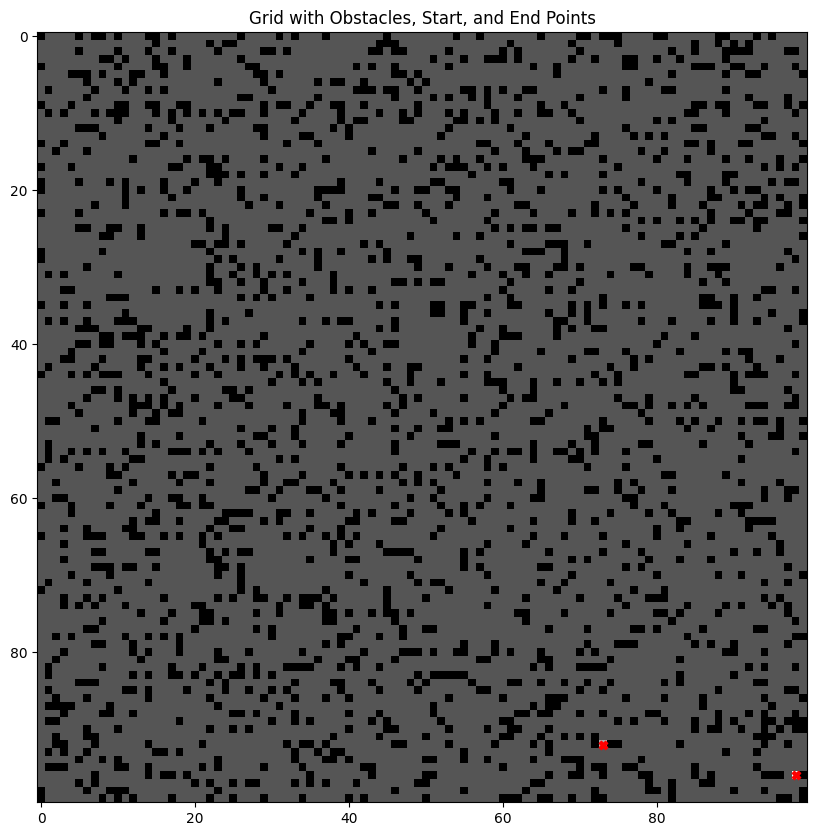

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap="gray")
plt.scatter([start[1], end[1]], [start[0], end[0]], c="red", marker="X")
plt.title("Grid with Obstacles, Start, and End Points")
plt.show()
